# UNet 车道线检测

# 一、环境准备

## 1.检查 CUDA 状态

多卡需禁用，或者运行后重启内核。

In [7]:
import torch

def check_cuda():
    flag = torch.cuda.is_available()
    if flag:
        print("CUDA可使用")
    else:
        print("CUDA不可用")

    # 获取GPU数量
    ngpu = torch.cuda.device_count()
    print("GPU数量：",ngpu)
    # Decide which device we want to run on
    device = torch.device("cuda:1" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
    print("驱动为：",device)
    print("GPU型号： ",torch.cuda.get_device_name(0))


check_cuda()

CUDA可使用
GPU数量： 2
驱动为： cuda:1
GPU型号：  NVIDIA GeForce RTX 3090


## 2.环境超参

In [8]:
from argparse import Namespace
import sys
sys.path.insert(0, '..')

config = Namespace(
    img_size = 128,
    lr = 1e-4,
    batch_size = 4,
    num_workers = 2,
)

# 二、数据准备

## 1.定义数据增强方式

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


def create_transform():
    train_transforms = A.Compose(
        [
            A.OneOf([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
            ]),
            ToTensorV2(p=1),
        ],
        p=1.0,
    )
    val_transforms = A.Compose(
        [
            ToTensorV2(p=1),
        ],
        p=1.0,
    )
    return train_transforms, val_transforms


## 2.定义 dataset 和 dataloader

In [10]:
from pathlib import Path
import torch
import torch.utils
import torchvision

from torch.utils.data import DataLoader
from custom.dataset import CustomDataset

def create_dataset():
    train_imgs = [
        str(x) for x in Path("../datasets/lane_lines/train").rglob("*.jpg")
        if 'checkpoint' not in str(x)
    ]

    val_imgs = [
        str(x) for x in Path('../datasets/lane_lines/val').rglob("*.jpg")
        if 'checkpoint' not in str(x)
    ]

    train_ts, val_ts = create_transform()
    train_ds = CustomDataset(train_imgs, config.img_size, train_ts)
    val_ds = CustomDataset(val_imgs, config.img_size, val_ts)

    return train_ds, val_ds


def create_dataloader(train_ds=None, val_ds=None):
    if train_ds is None and val_ds is None:
        train_ds, val_ds = create_dataset()

    train_dl = DataLoader(
        train_ds, batch_size=config.batch_size, 
        shuffle=True, num_workers=config.num_workers
    )
    val_dl = DataLoader(
        val_ds, batch_size=config.batch_size,
        shuffle=False, num_workers=config.num_workers
    )
    return train_dl, val_dl


train_dataset, val_dataset = create_dataset()
train_dataloader, val_dataloader = create_dataloader(train_dataset, val_dataset)


## 3.检查数据

torch.Size([4, 3, 128, 128]) torch.Size([4, 1, 128, 128])


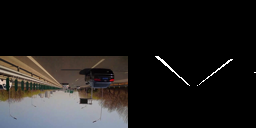

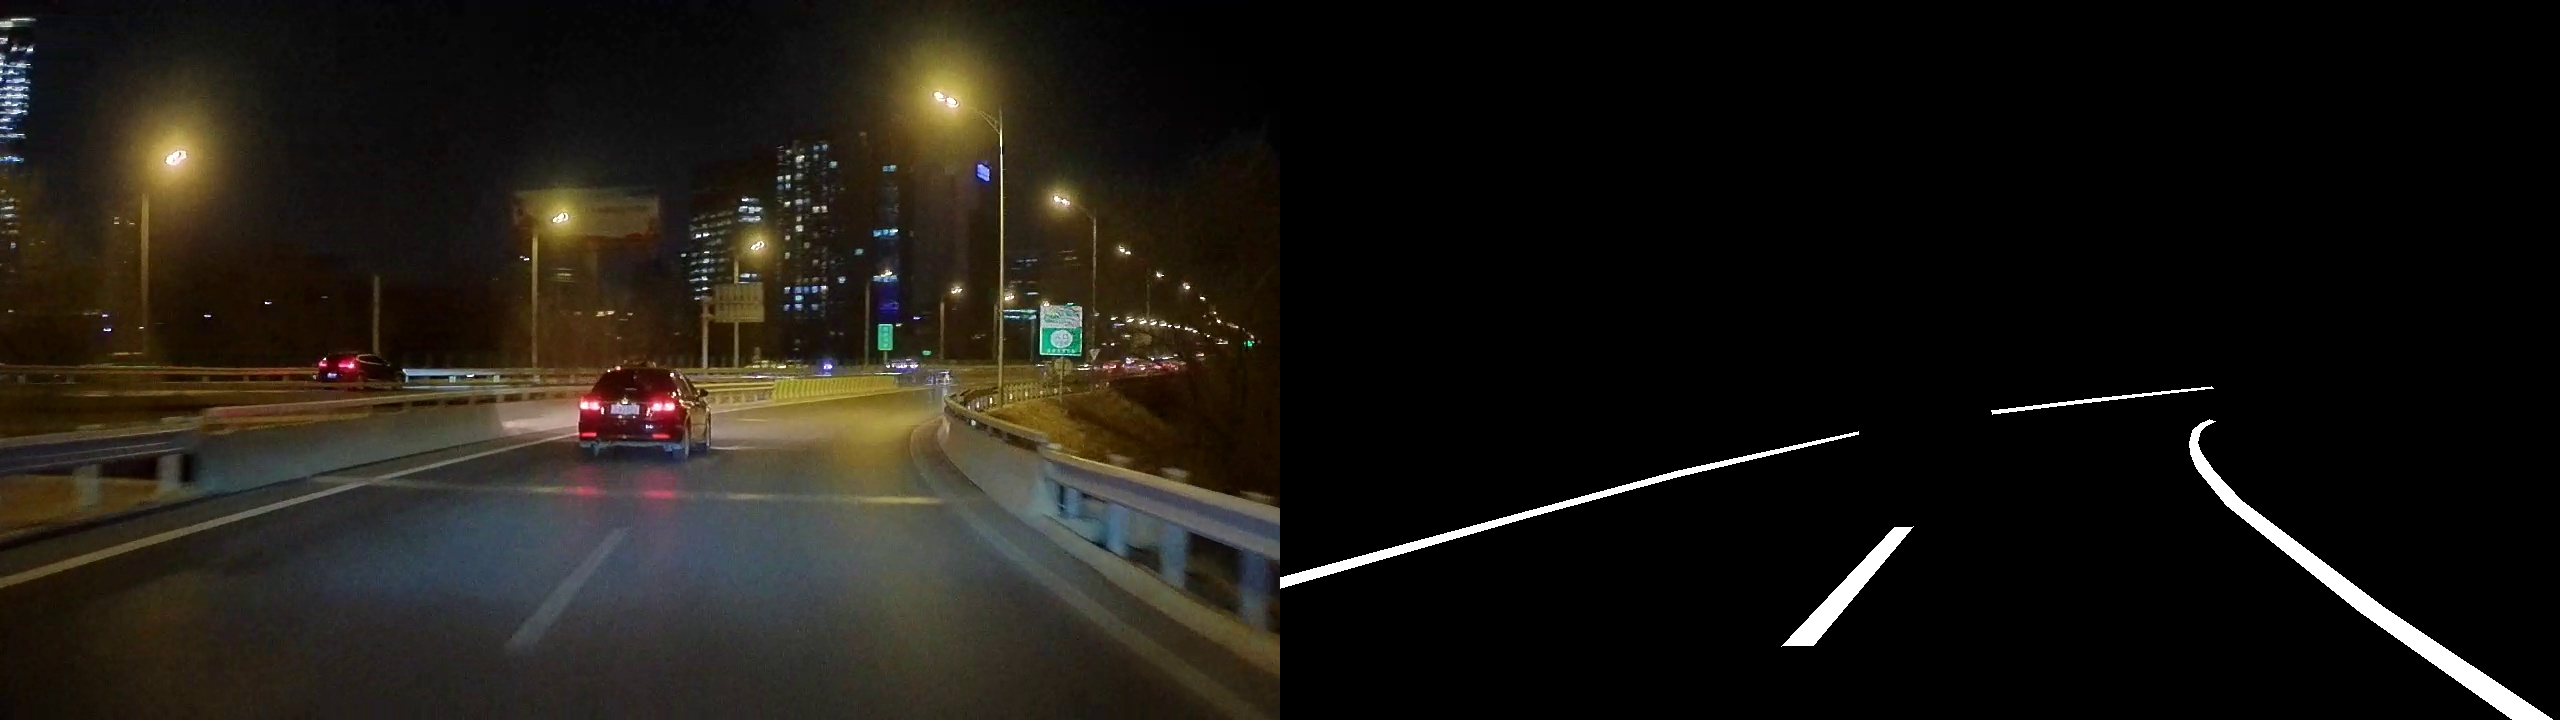

In [11]:
import numpy as np
from PIL import Image
from torchkeras.plots import joint_imgs_row

for batch in train_dataloader:
    image = batch['image']
    mask = batch['mask']
    print(image.shape, mask.shape)
    # tensor -> numpy -> PIL
    image = image[0].permute(1, 2, 0).numpy() * 255
    mask = mask[0].permute(1, 2, 0).numpy().squeeze()
    mask = np.where(mask > 0.5, 255, 0).astype(np.uint8)
    image = Image.fromarray(image.astype(np.uint8))
    mask = Image.fromarray(mask)
    display(joint_imgs_row(image, mask))
    break

display(train_dataset.show_sample(10))

# 三、训练准备

## 1.定义模型

In [12]:
import segmentation_models_pytorch as smp # type: ignore

net = smp.DeepLabV3Plus(
    encoder_name="mobilenet_v2",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/zijieshen/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:01<00:00, 7.62MB/s]


## 2.定义 loss、optimizer、lr_scheduler、metrics_dict

In [13]:
import torch
from torchkeras.metrics import IOU
from torchkeras.kerasmodel import KerasModel
from custom.loss import MixedLoss, DiceLoss

optim = torch.optim.Adam(net.parameters(), lr=config.lr)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, T_max=8, eta_min=1e-6
)
metrics = {
    "iou": IOU(num_classes=1)
}


## 3.定义 torckkeras 模型

In [14]:
model = KerasModel(
    net, loss_fn=MixedLoss(0.5), optimizer=optim, lr_scheduler=lr_scheduler, metrics_dict=metrics
)

## 4.定义训练 StepRunner

In [15]:
from importlib import reload
from torchkeras import kerasmodel, pbar
from custom.step import StepRunner

# reload(kerasmodel)
# reload(pbar)

kerasmodel.KerasModel.StepRunner = StepRunner

# 四、训练

## 1.Wandb记录、VisDisplay展示

In [16]:
from importlib import reload
from torchkeras import kerasmodel, kerascallbacks
reload(kerascallbacks)

from torchkeras.kerascallbacks import WandbCallback
from torchkeras.kerascallbacks import VisDisplay


def display_fn(model):
    from matplotlib import pyplot as plt
    batch = next(iter(val_dataloader))

    with torch.no_grad():
        model.eval()
        logits = model(batch["image"].cuda())
    pr_masks = logits.sigmoid()

    for image, gt_mask, pr_mask in zip(batch["image"][:2], batch["mask"][:2], pr_masks[:2]):
        plt.figure(figsize=(16, 10))

        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.cpu().numpy().squeeze())
        plt.title("Prediction")
        plt.axis("off")

        plt.show()


wandb_cb = WandbCallback(
    project='lane_lines',
    config=config.__dict__,
    name=None,
    save_code=True,
    save_ckpt=True,
)

visdis_cb = VisDisplay(display_fn,model = model,init_display=False)


## 2.单卡训练

<<<<<< ⚡️ cuda is used >>>>>>


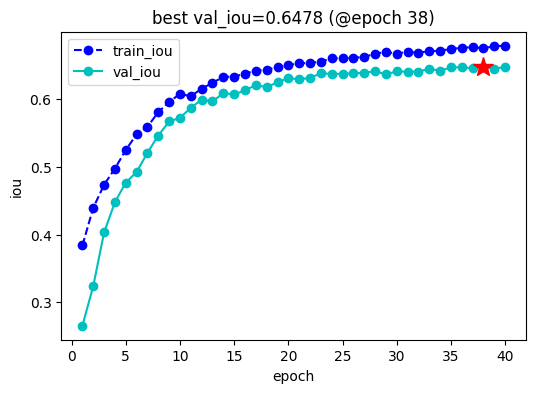

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: zijie-shen795 (uestc-cd). Use `wandb login --relogin` to force relogin


Output()

best_val_iou,▁▂▄▄▅▅▆▆▇▇▇▇▇▇▇▇████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▅▁▅█▅▁▅█▅▁▅█▅▁▅█▅▁▅█▅▁▅█▅▁▅█▅▁▅█▅▁▅█▅▁▅█
train_iou,▁▂▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████████
train_loss,██▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_iou,▁▂▄▄▅▅▆▆▇▇▇▇▇▇▇▇█▇██████████████████████
val_loss,██▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_score,0.6478
best_val_iou,0.6478
epoch,40.0
lr,0.0001


********** training finished **********
********** best model loaded **********


In [17]:

dfhistory=model.fit(
    train_data=train_dataloader,
    val_data=val_dataloader,
    epochs=40,
    ckpt_path='checkpoint.pt',
    patience=5,
    monitor="val_iou",
    mode="max",
    mixed_precision='no',
    callbacks = [wandb_cb,visdis_cb],
    plot=True,
    cpu=False,
    quiet=True,
)


## 3.多卡训练

需重启内核，禁用 1.1 cuda 检测，并且之前不能运行任何训练代码。

Launching training on 2 GPUs.
<<<<<< ⚡️ cuda:0 is used >>>>>>


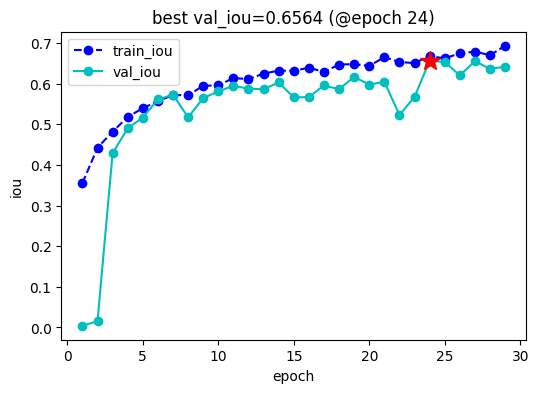

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: zijie-shen795 (uestc-cd). Use `wandb login --relogin` to force relogin


Output()

best_val_iou,▁▁▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
lr,▅▁▅█▅▁▅█▅▁▅█▅▁▅█▅▁▅█▅▁▅█▅▁▅█▅
train_iou,▁▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████
train_loss,█▇▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_iou,▁▁▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇██████
val_loss,██▇▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▃▂▁▁▁▁▁▁
best_score,0.65638
best_val_iou,0.65638
epoch,29.0
lr,5e-05


<<<<<< val_iou without improvement in 5 epoch,early stopping >>>>>> 

********** training finished **********
********** best model loaded **********


In [11]:
args = dict(
    train_data = train_dataloader,
    val_data = val_dataloader,
    epochs = 40,
    ckpt_path = "checkpoint.pt",
    patience = 5,
    monitor = 'val_iou',
    mode = 'max',
    mixed_precision = 'no',
    callbacks = [wandb_cb, visdis_cb],
    plot = True,
    cpu = False,
    quiet = None
)

dfhistory = model.fit_ddp(
    num_processes=2,
    **args
)

## 4.查看训练结果

只能单卡查看，多卡如果需要查看，就去 wandb。

In [18]:
from importlib import reload 
from torchkeras import plots
reload(plots)
from torchkeras.plots import plot_metric 

plot_metric(dfhistory,'iou')

In [ ]:
plot_metric(dfhistory,'loss')

## 5、模型验证

In [13]:
model.evaluate(val_dataloader)

100%|████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s, val_iou=0.00427, val_loss=0.854]


{'val_loss': 0.8539437174797058, 'val_iou': 0.0042724609375}

# 五、模型推理

重启内核，不要运行第四章。

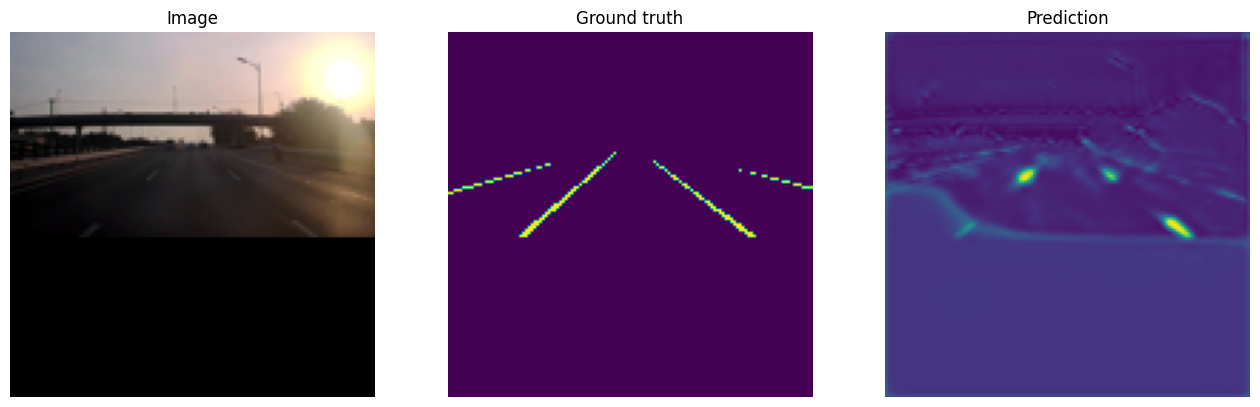

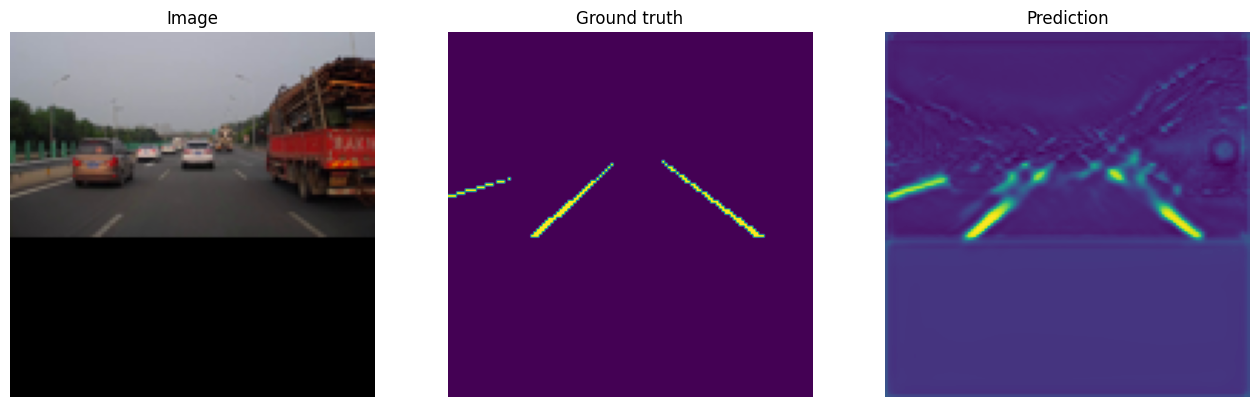

In [19]:
import matplotlib.pyplot as plt
import torch


model.load_ckpt('checkpoint.pt')

net = model.net
net.eval()

batch = next(iter(val_dataloader))

logits = net(batch["image"])
pr_masks = logits.sigmoid()


# with torch.no_grad():
#     model.eval()
#     logits = model(batch["image"].cuda())
    
# pr_masks = logits.sigmoid()


for image, gt_mask, pr_mask in zip(batch["image"][:2], batch["mask"][:2], pr_masks[:2]):
    plt.figure(figsize=(16, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) 
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.detach().cpu().numpy().squeeze()) 
    plt.title("Prediction")
    plt.axis("off")

    plt.show()